In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nltk.tokenize import word_tokenize
import pandas as pd
import spacy
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf


nlp = spacy.load("en_core_web_sm")

### Context
- This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

### Content
**It contains the following 6 fields:**

- **target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)**
- **ids: The id of the tweet ( 2087)**

- **date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)**

- **flag: The query (lyx). If there is no query, then this value is NO_QUERY.**

- **user: the user that tweeted (robotickilldozr)**
- **text: the text of the tweet (Lyx is cool)**



In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d crowdflower/twitter-airline-sentiment

Dataset URL: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
License(s): CC-BY-NC-SA-4.0
twitter-airline-sentiment.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip twitter-airline-sentiment.zip

Archive:  twitter-airline-sentiment.zip
replace Tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
data = pd.read_csv("Tweets.csv")

In [4]:
data = data[['airline_sentiment', 'airline_sentiment_confidence', 'airline', 'retweet_count', 'text']]

In [5]:
data.head()

,airline_sentiment,airline_sentiment_confidence,airline,retweet_count,text
0,neutral,1.0000,Virgin America,0,@VirginAmerica What @dhepburn said.
1,positive,0.3486,Virgin America,0,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,Virgin America,0,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,Virgin America,0,@VirginAmerica and it's a really big bad thing...


In [6]:
data.shape

(14640, 5)

In [7]:
data.isna().sum()

airline_sentiment               0
airline_sentiment_confidence    0
airline                         0
retweet_count                   0
text                            0
dtype: int64

In [8]:
data['airline_sentiment'] = data['airline_sentiment'].map({
    "positive": 'Positive',
    "neutral": 'Neutral',
    "negative": 'Negative'
})

In [9]:
data['airline_sentiment_labelled'] = data['airline_sentiment'].map({'Positive': 1, 'Neutral': 0, 'Negative': 2})

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airline_sentiment             14640 non-null  object 
 1   airline_sentiment_confidence  14640 non-null  float64
 2   airline                       14640 non-null  object 
 3   retweet_count                 14640 non-null  int64  
 4   text                          14640 non-null  object 
 5   airline_sentiment_labelled    14640 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 686.4+ KB


In [11]:
data['airline_sentiment'].value_counts()

airline_sentiment
Negative    9178
Neutral     3099
Positive    2363
Name: count, dtype: int64

/var/folders/3r/s5g8pkxj3zq5lhhklkgsdfwm0000gn/T/ipykernel_87346/3757371829.py:3: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x='airline_sentiment',  hue='airline_sentiment', palette=['#05ddf5', '#de0bc2'], edgecolor='black', data=data)


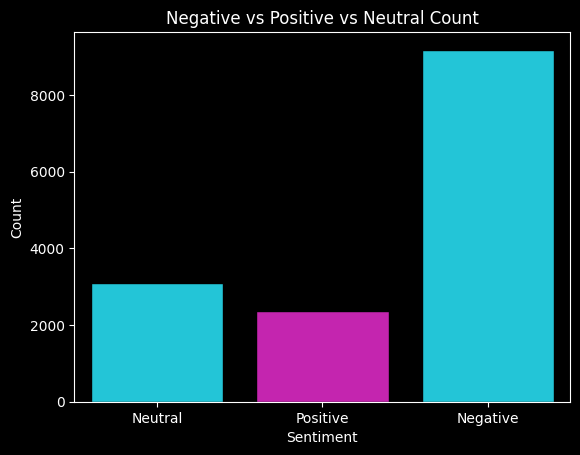

In [12]:
plt.style.use('dark_background')
plt.title("Negative vs Positive vs Neutral Count")
sns.countplot(x='airline_sentiment',  hue='airline_sentiment', palette=['#05ddf5', '#de0bc2'], edgecolor='black', data=data)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [13]:
def process_tweet(tweet):
    doc = nlp(tweet.lower())

    tokens = [
        token.text for token in doc
        if not token.is_punct  # Remove punctuation
        and not token.is_space  # Remove extra spaces
        and not token.like_url  # Remove URLs
        and not token.like_email  # Remove email addresses (if needed)
        and not token.text.startswith('@')  # Remove mentions
        and (token.is_alpha or token.is_digit)  # Keep alphanumeric tokens
    ]

    return tokens

def preprocess(text):
    doc = nlp(text.lower())
    cleaned_tokens = [
        token.lemma_
        for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha and not token.text.startswith('@')
    ]
    return " ".join(cleaned_tokens)

In [14]:
data['Processed_text'] = data['text'].apply(preprocess)

In [15]:
data.head()

,airline_sentiment,airline_sentiment_confidence,airline,retweet_count,text,airline_sentiment_labelled,Processed_text
0,Neutral,1.0000,Virgin America,0,@VirginAmerica What @dhepburn said.,0,say
1,Positive,0.3486,Virgin America,0,@VirginAmerica plus you've added commercials t...,1,plus add commercial experience tacky
2,Neutral,0.6837,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...,0,today mean need trip
3,Negative,1.0000,Virgin America,0,@VirginAmerica it's really aggressive to blast...,2,aggressive blast obnoxious entertainment guest...
4,Negative,1.0000,Virgin America,0,@VirginAmerica and it's a really big bad thing...,2,big bad thing


In [16]:
X_train, X_test, y_train, y_test = train_test_split(data['Processed_text'], data['airline_sentiment_labelled'], test_size=0.2, random_state=42)

In [17]:
embedding_dim = 100
embedding_path = "/Users/innovationinsight/Desktop/Umer/glove.6B/glove.6B.100d.txt"

def load_embeddings(path):
    embeddings = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings

embeddings_index = load_embeddings(embedding_path)
print(f"Loaded {len(embeddings_index)} word vectors.")

Loaded 400000 word vectors.


In [18]:
def text_to_embedding(text, embeddings_index, embedding_dim):
    doc = nlp(text)
    vectors = [
        embeddings_index.get(token.text, np.zeros(embedding_dim))
        for token in doc
    ]
    return vectors

def vectorize_texts(texts, embeddings_index, embedding_dim, max_len):
    sequences = [text_to_embedding(text, embeddings_index, embedding_dim) for text in texts]
    padded_sequences = pad_sequences(sequences, maxlen=max_len, dtype="float32", padding="post", truncating="post")
    return padded_sequences

In [19]:
max_len = 50
X_train_vec = vectorize_texts(X_train, embeddings_index, embedding_dim, max_len)
X_test_vec = vectorize_texts(X_test, embeddings_index, embedding_dim, max_len)

In [20]:
X_train_vec.shape, X_test_vec.shape

((11712, 50, 100), (2928, 50, 100))

In [27]:
def create_dense_model(embedding_dim, max_len):
    model = tf.keras.models.Sequential([
        # Input Layer (Flatten the embeddings)
        tf.keras.layers.Input(shape=(max_len, embedding_dim)),
        tf.keras.layers.Flatten(),

        # Fully Connected Layers
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        
        # Output Layer (Softmax for multi-class classification)
        tf.keras.layers.Dense(3, activation="softmax")
    ])

    # Compile the Model
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )
    return model


In [28]:
model = create_model(embedding_dim, max_len)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 50, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 50, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,811 (1.62 MB)

 Trainable params: 423,811 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(X_train_vec, y_train, validation_data=(X_test_vec, y_test), epochs=10, batch_size=32)

Epoch 1/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 61s 159ms/step - accuracy: 0.6458 - loss: 0.8209 - val_accuracy: 0.7298 - val_loss: 0.6395
Epoch 2/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 66s 179ms/step - accuracy: 0.7312 - loss: 0.6634 - val_accuracy: 0.7640 - val_loss: 0.5775
Epoch 3/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 67s 182ms/step - accuracy: 0.7487 - loss: 0.6191 - val_accuracy: 0.7643 - val_loss: 0.5753
Epoch 4/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 67s 184ms/step - accuracy: 0.7568 - loss: 0.5959 - val_accuracy: 0.7739 - val_loss: 0.5433
Epoch 5/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 65s 178ms/step - accuracy: 0.7690 - loss: 0.5729 - val_accuracy: 0.7783 - val_loss: 0.5391
Epoch 6/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 68s 186ms/step - accuracy: 0.7812 - loss: 0.5482 - val_accuracy: 0.7842 - val_loss: 0.5492
Epoch 7/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 67s 182ms/step - accuracy: 0.7866 - loss: 0.5349 - val_accuracy: 0.7821 - val_loss: 0.5230
Epoch 8/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 66s 181ms/step - accuracy: 0.8028 - loss: 0

In [30]:
model.evaluate(X_test_vec, y_test)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7853 - loss: 0.5559


[0.5629016160964966, 0.7838114500045776]

In [31]:
def plot_training_history(history):
    plt.style.use('dark_background')

    accuracy = history.history.get('accuracy', [])
    val_accuracy = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs = range(1, len(accuracy) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(epochs, accuracy, label='Training Accuracy', color='#05ddf5', marker='o', linewidth=2)
    ax[0].plot(epochs, val_accuracy, label='Validation Accuracy', color='#de0bc2', marker='o', linewidth=2)
    ax[0].set_title('Training and Validation Accuracy', fontsize=14)
    ax[0].set_xlabel('Epochs', fontsize=12)
    ax[0].set_ylabel('Accuracy', fontsize=12)
    ax[0].legend()
    ax[0].grid(color='gray', linestyle='--', linewidth=0.5)

    ax[1].plot(epochs, loss, label='Training Loss', color='#05ddf5', marker='o', linewidth=2)
    ax[1].plot(epochs, val_loss, label='Validation Loss', color='#de0bc2', marker='o', linewidth=2)
    ax[1].set_title('Training and Validation Loss', fontsize=14)
    ax[1].set_xlabel('Epochs', fontsize=12)
    ax[1].set_ylabel('Loss', fontsize=12)
    ax[1].legend()
    ax[1].grid(color='gray', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

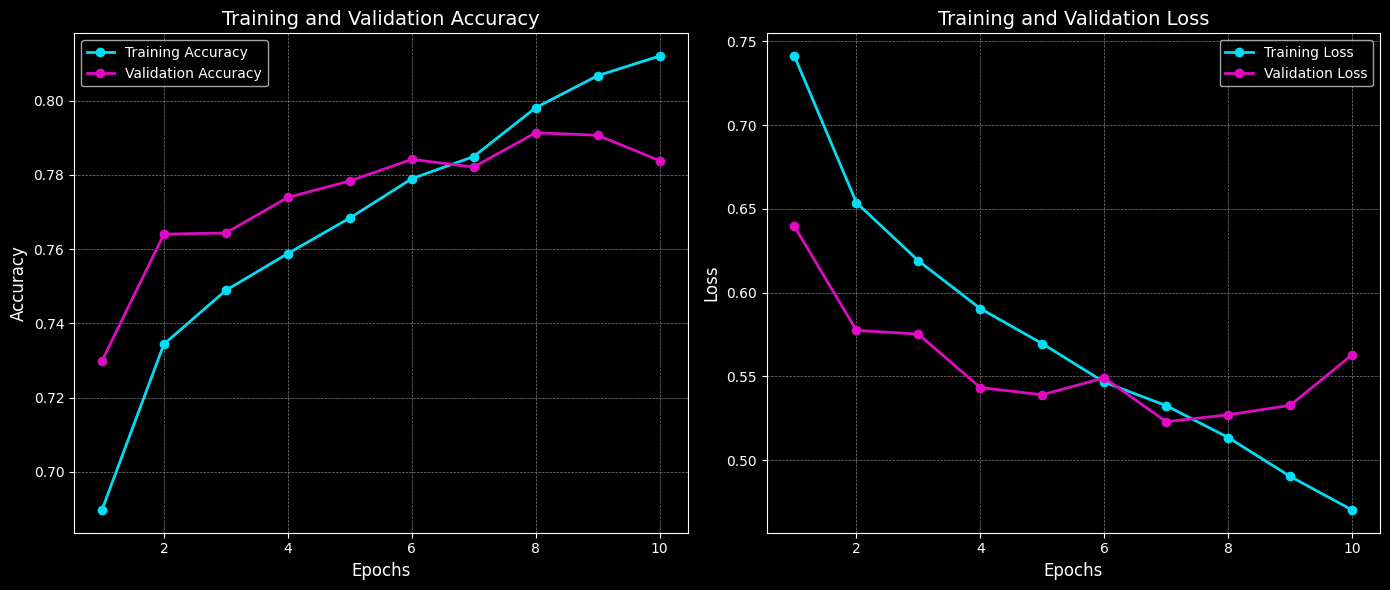

In [32]:
plot_training_history(history)